# Comparing ANHA4 Ba with Obs

This is the notebook I used to compare modeled Ba with field observations. - 2016/01/26

** Model output: **

* Spin-up 6 years (2002-2004)*2
* ANHA4-EXH001

** Observations: **

* GIPY11 Aug 2007
* BGEP Aug 2003-2005
* HLY Aug 2003
* CBL Sep 2002

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
#sys.setdefaultencoding('utf8')
sys.path.insert(0, '_libs/')

In [3]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, cm
% matplotlib inline

In [4]:
from NEMO_tools import int_profile, bin_profile, find_inland, reporj_NEMOgrid

In [142]:
# nonlinear colormap, borrowed from Robert Hetland <hetland@tamu.edu>, under MIT license.
# http://protracted-matter.blogspot.ca/2012/08/nonlinear-colormap-in-matplotlib.html
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    name = 'nlcmap'    
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels / self.levels.max()
        self._y = np.linspace(0.0, 1.0, len(self.levels))
    def __call__(self, xi, alpha=1.0, **kw):
        """docstring for fname"""
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

In [5]:
np.set_printoptions(threshold='nan')

# Get the data ready

In [6]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/GIPY11_Ba.mat')
GIPY_lons = MAT['Ba_records'][:, 0]
GIPY_lats = MAT['Ba_records'][:, 1]
GIPY_deps = MAT['Ba_records'][:, 2]
GIPY_Ba   = MAT['Ba_records'][:, 3]
#
GIPY_lons[GIPY_lons>180]=GIPY_lons[GIPY_lons>180]-360

In [7]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/BGEP_Ba.mat')
x03 = MAT['Ba2003'][:, 1]; y03 = MAT['Ba2003'][:, 0]; z03 = MAT['Ba2003'][:, 2]; Ba03 = MAT['Ba2003'][:, 3]
x04 = MAT['Ba2004'][:, 1]; y04 = MAT['Ba2004'][:, 0]; z04 = MAT['Ba2004'][:, 2]; Ba04 = MAT['Ba2004'][:, 3]
x04[Ba04<0]=np.nan; y04[Ba04<0]=np.nan; z04[Ba04<0]=np.nan; Ba04[Ba04<0]=np.nan
x05 = MAT['Ba2005'][:, 1]; y05 = MAT['Ba2005'][:, 0]; z05 = MAT['Ba2005'][:, 2]; Ba05 = MAT['Ba2005'][:, 3]

In [8]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/HLY_Ba.mat')
xH = np.squeeze(MAT['lon'][:]); yH = np.squeeze(MAT['lat'][:]); zH = np.squeeze(MAT['dep'][:]); BaH = np.squeeze(MAT['Ba'][:])

In [9]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/CBL_Ba.mat')
xC = np.squeeze(MAT['lon'][:]); yC = np.squeeze(MAT['lat'][:]); zC = np.squeeze(MAT['dep'][:]); BaC = np.squeeze(MAT['Ba'][:])

In [10]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/ARK09_Ba.mat')
xA9 = np.squeeze(MAT['lon'][:]); yA9 = np.squeeze(MAT['lat'][:]); zA9 = np.squeeze(MAT['dep'][:]); BaA9 = np.squeeze(MAT['Ba'][:])

In [11]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/ARK14_Ba.mat')
xA14 = np.squeeze(MAT['lon'][:]); yA14 = np.squeeze(MAT['lat'][:]); zA14 = np.squeeze(MAT['dep'][:]); BaA14 = np.squeeze(MAT['Ba'][:])

In [12]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/NPEO_Ba.mat')
xNPEO = np.squeeze(MAT['lon'][:]); yNPEO = np.squeeze(MAT['lat'][:]); zNPEO = np.squeeze(MAT['dep'][:]); BaNPEO = np.squeeze(MAT['Ba'][:])

In [13]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/ARC_Ba.mat')
xARC = np.squeeze(MAT['lon'][:]); yARC = np.squeeze(MAT['lat'][:]); zARC = np.squeeze(MAT['dep'][:]); BaARC = np.squeeze(MAT['Ba'][:])

In [14]:
BGEP_lons = np.hstack((x03, x04, x05))
BGEP_lats = np.hstack((y03, y04, y05))
BGEP_deps = np.hstack((z03, z04, z05))
BGEP_Ba   = np.hstack((Ba03, Ba04, Ba05))

In [15]:
x_all = np.hstack((GIPY_lons, x03, x04, x05, xH, xC)) # xA14, xNPEO, xARC
y_all = np.hstack((GIPY_lats, y03, y04, y05, yH, yC))
z_all = np.hstack((GIPY_deps, z03, z04, z05, zH, zC))
Ba_all = np.hstack((GIPY_Ba, Ba03, Ba04, Ba05, BaH, BaC))

In [16]:
ANHA4_MAT=scipy.io.loadmat('_data/Exchange/coord_ANHA4.mat')
deptht = ANHA4_MAT['nav_lev'][:]

In [18]:
tar_dep = 5250
dep_surf = deptht[deptht<tar_dep]

x_surf = x_all[z_all<tar_dep]; y_surf = y_all[z_all<tar_dep]; z_surf = z_all[z_all<tar_dep]; Ba_surf = Ba_all[z_all<tar_dep]

In [19]:
intx, inty, out_surf = int_profile(x_surf, y_surf, z_surf, Ba_surf, dep_surf, thres=2000)

In [52]:
out_dep = np.ones([275, 48])*dep_surf

In [56]:
#Ba_sample = out_surf.flatten()
#d = out_dep.flatten()

In [20]:
#200708*446 200308*349 200408*399 200508*389 200308*570 200209*967

In [21]:
year = np.array([200708, 200308, 200408, 200508, 200308, 200209])
time_ind = np.array([66, 19, 31, 42, 19, 8]) # 
#proxy_Ba = np.argsort(time_ind)
#time_ind = np.sort(time_ind)
time_ind = np.array([8, 19, 31, 42, 66])
proxy_Ba = [4, 1, 2, 3, 1, 0]
time_limit = np.array([446, 446+349, 446+349+399, 446+349+399+389, 446+349+399+389+570, 446+349+399+389+570+967])-1

# Model output

In [22]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/SPIN06_SET02_1m_20020101_20131231_ptrc_T.nc'

In [23]:
ptrc_obj = nc.Dataset(FName)
Ba = np.squeeze(ptrc_obj.variables['Ba'][time_ind, :, :, :]) #67
Ba[Ba==0]=np.nan
Ba = Ba-4
Ba2 = np.squeeze(ptrc_obj.variables['Ba'][time_ind, :, :, :])
Ba2[np.isnan(Ba)]=np.nan
nav_lat = ptrc_obj.variables['nav_lat'][:]
nav_lon = ptrc_obj.variables['nav_lon'][:]
deptht = ptrc_obj.variables['deptht'][:]

In [31]:
#x = x_all[z_all<tar_dep]
#y = y_all[z_all<tar_dep]
#Ba_sample = Ba_all[z_all<tar_dep]
#d = z_all[z_all<tar_dep]

In [59]:
locx, locy = Nts.nearest_search(nav_lon, nav_lat, intx, inty)

# Comparisons

In [33]:
def unique_continue(x):
    # Has the functionality of numpy.unique but work with "repeated and continued" elements    
    A = np.diff(x)
    head = [0]
    counts = []
    sub_counts = 1
    for i in range(len(A)):
        if A[i] == 0:
            sub_counts += 1
        else:
            counts.insert(len(counts), sub_counts)            
            sub_counts = 1
            head.insert(len(counts), i)
        # deal with the end of an array
        if i == len(A)-1:
            counts.insert(len(counts), sub_counts)            
            sub_counts = 1
            head.insert(len(counts), i)
    return np.array(head), np.array(counts)

In [40]:
head_loc, counts_loc = unique_continue(locx*locy)
head_loc[1:]=head_loc[1:]+1

In [65]:
len(head_loc)-1

265

In [84]:
Ba_model = np.zeros([265, 48])


for i in range(265):
    
    t_loc = np.searchsorted(time_limit, head_loc[i])
    Ba_t = Ba[proxy_Ba[t_loc], :, :, :]
    #Ba_t2 = Ba2[proxy_Ba[t_loc], :, :, :]
    
    #fig = plt.figure(figsize=(8, 10))
    #ax = fig.gca(); ax.grid()
    #ax.set_ylim(-10, 900); ax.invert_yaxis()
    #ax.plot(Ba_t[:, locx[i], locy[i]], deptht, 'bo', lw=2.5)
    Ba_model[i, :] = Ba_t[0:-2, locx[i], locy[i]]
    
    #ax.plot(Ba_t[:, locx[head_loc[i]], locy[head_loc[i]]], deptht, 'bo', lw=2.5)
    #ax.plot(Ba_t2[:, locx[head_loc[i]], locy[head_loc[i]]], deptht, 'k--')
    
    #ax.plot(Ba_sample[head_loc[i]:(head_loc[i]+counts_loc[i])], d[head_loc[i]:(head_loc[i]+counts_loc[i])], 'ro', ms=8)
    #ax.plot(out_surf[i, :], out_dep[i, :], 'ro', ms=8)
    #ax.set_title('Time: {} Profile {}: nav_lon[{}], nav_lat[{}]'.format(year[t_loc], i, locx[head_loc[i]], locy[head_loc[i]]))
    #ax.set_xlim([20, 90])

In [85]:
Ba_sample = out_surf[0:265, :].flatten()
Ba_model = Ba_model.flatten()
Ba_model = Ba_model[Ba_sample>0]
Ba_sample = Ba_sample[Ba_sample>0]
d = out_dep.flatten()

In [135]:
# create bins for channel-31 
model_bins = 150
model_lim=[20, 90]
model_bins=np.linspace(model_lim[0], model_lim[1], model_bins, dtype=np.float)
# and channel-1
sample_bins = 150
sample_lim=[20, 90]
sample_bins=np.linspace(sample_lim[0], sample_lim[1], sample_bins, dtype=np.float)

In [136]:
y=Ba_model; y_bins=model_bins # x: C31
x=Ba_sample; x_bins=sample_bins # y: C1
H, y_edges, x_edges = np.histogram2d(y, x, bins=(y_bins, x_bins))
X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])

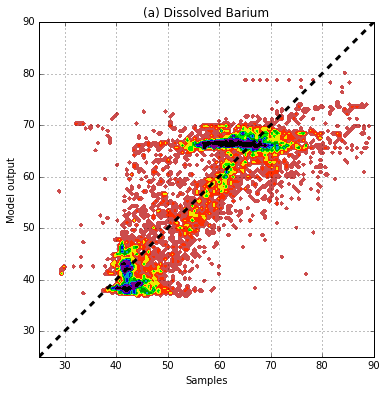

In [145]:
# make_axes_locatable ---> for axis control
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(6, 6))
axMain = fig.gca(); axMain.grid()
clevs=[1, 5, 10, 15, 20, 25, 30, 35, 50]
CMap = nlcmap(plt.cm.nipy_spectral_r, clevs)
xlim_bin=[25, 90]
ylim_bin=[25, 90]
axMain.set_xlim(xlim_bin)
axMain.set_ylim(ylim_bin)
axMain.set_xlabel('Samples')
axMain.set_ylabel('Model output')
axMain.set_title('(a) Dissolved Barium')
divider=make_axes_locatable(axMain)
CS=axMain.contourf(X, Y, H/np.max(H)*100, clevs, cmap=CMap, extend='max')
axMain.plot([25, 90], [25, 90], 'k--', lw=3)
fig.savefig('_publish/FIG14_1.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
                bbox_inches='tight', pad_inches=0.1)

In [303]:
good = [0, 1, 2, 4, 5, 9, 12, 13, 14, 16, 17, 18, 19, 20, 22, 31, 32, 33, 34, 35, 36, 37, 51, 54, 55, 56, 59, 62, 66, \
        68, 113, 133, 134, 135, 136, 137, 138, 139, 140, 142, 145, 148, 151, 152, 153, 154, 155, 159, 160, 161, 162, \
        163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 211, 212, 213, 214, 215, 216, \
        217, 219, 220, 221, 240, 241, 245, 246, 247, 249, 250, 251, 253, 254, 257, 259, 261]
soso = [25, 26, 27, 28, 29, 30, 38, 41, 49, 53, 65, 67, 105, 107, 120, 125, 126, 127, 128, 129, 130, 131, 132, 141, 150, \
        157, 158, 218, 248, 252, 260, 263]
ueh  = [42, 43, 44, 45, 47, 48, 50, 57, 58, 60, 61, 63, 64, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, \
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 109, 114, 115, 116, 117, 118, 119, 121, 122, \
       123, 124, 156, 231, 232, 233, 234, 235, 236, 237, 238, 239, 242, 243, 244, 255, 256, 258, 262, 264]
oes  = [3, 6, 7, 8, 15, 21, 23, 24, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, \
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 222, 223, 224, 225, 226, 227, 228, 229, 230]
bad  = [39, 40, 46, 71, 102, 103, 104, 106, 108, 110, 111, 112]
nan  = [10, 11, 101, 146, 147]

In [302]:
def big_box():
    fig = plt.figure(figsize=(14, 8*6))
    ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((6, 4), (0, 1), colspan=1, rowspan=1)
    ax3 = plt.subplot2grid((6, 4), (0, 2), colspan=1, rowspan=1)
    ax4 = plt.subplot2grid((6, 4), (0, 3), colspan=1, rowspan=1)

    ax5 = plt.subplot2grid((6, 4), (1, 0), colspan=1, rowspan=1)
    ax6 = plt.subplot2grid((6, 4), (1, 1), colspan=1, rowspan=1)
    ax7 = plt.subplot2grid((6, 4), (1, 2), colspan=1, rowspan=1)
    ax8 = plt.subplot2grid((6, 4), (1, 3), colspan=1, rowspan=1)

    ax9 = plt.subplot2grid((6, 4), (2, 0), colspan=1, rowspan=1)
    ax10 = plt.subplot2grid((6, 4), (2, 1), colspan=1, rowspan=1)
    ax11 = plt.subplot2grid((6, 4), (2, 2), colspan=1, rowspan=1)
    ax12 = plt.subplot2grid((6, 4), (2, 3), colspan=1, rowspan=1)

    ax13 = plt.subplot2grid((6, 4), (3, 0), colspan=1, rowspan=1)
    ax14 = plt.subplot2grid((6, 4), (3, 1), colspan=1, rowspan=1)
    ax15 = plt.subplot2grid((6, 4), (3, 2), colspan=1, rowspan=1)
    ax16 = plt.subplot2grid((6, 4), (3, 3), colspan=1, rowspan=1)

    ax17 = plt.subplot2grid((6, 4), (4, 0), colspan=1, rowspan=1)
    ax18 = plt.subplot2grid((6, 4), (4, 1), colspan=1, rowspan=1)
    ax19 = plt.subplot2grid((6, 4), (4, 2), colspan=1, rowspan=1)
    ax20 = plt.subplot2grid((6, 4), (4, 3), colspan=1, rowspan=1)

    ax21 = plt.subplot2grid((6, 4), (5, 0), colspan=1, rowspan=1)
    ax22 = plt.subplot2grid((6, 4), (5, 1), colspan=1, rowspan=1)
    ax23 = plt.subplot2grid((6, 4), (5, 2), colspan=1, rowspan=1)
    ax24 = plt.subplot2grid((6, 4), (5, 3), colspan=1, rowspan=1)
    
    AX = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, \
          ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22, ax23, ax24]
    
    return fig, AX

In [291]:
def signle_plot(num, ax):
    t_loc = np.searchsorted(time_limit, head_loc[num])
    Ba_t = Ba[proxy_Ba[t_loc], :, :, :]    
    ax.plot(Ba_t[:, locx[head_loc[num]], locy[head_loc[num]]], deptht, 'k-', lw=2.5)
    ax.plot(Ba_sample[head_loc[num]:(head_loc[num]+counts_loc[num])], \
            d[head_loc[num]:(head_loc[num]+counts_loc[num])], 'ro', ms=8)
    ax.set_title('Time: {} Profile {}'.format(year[t_loc], num))

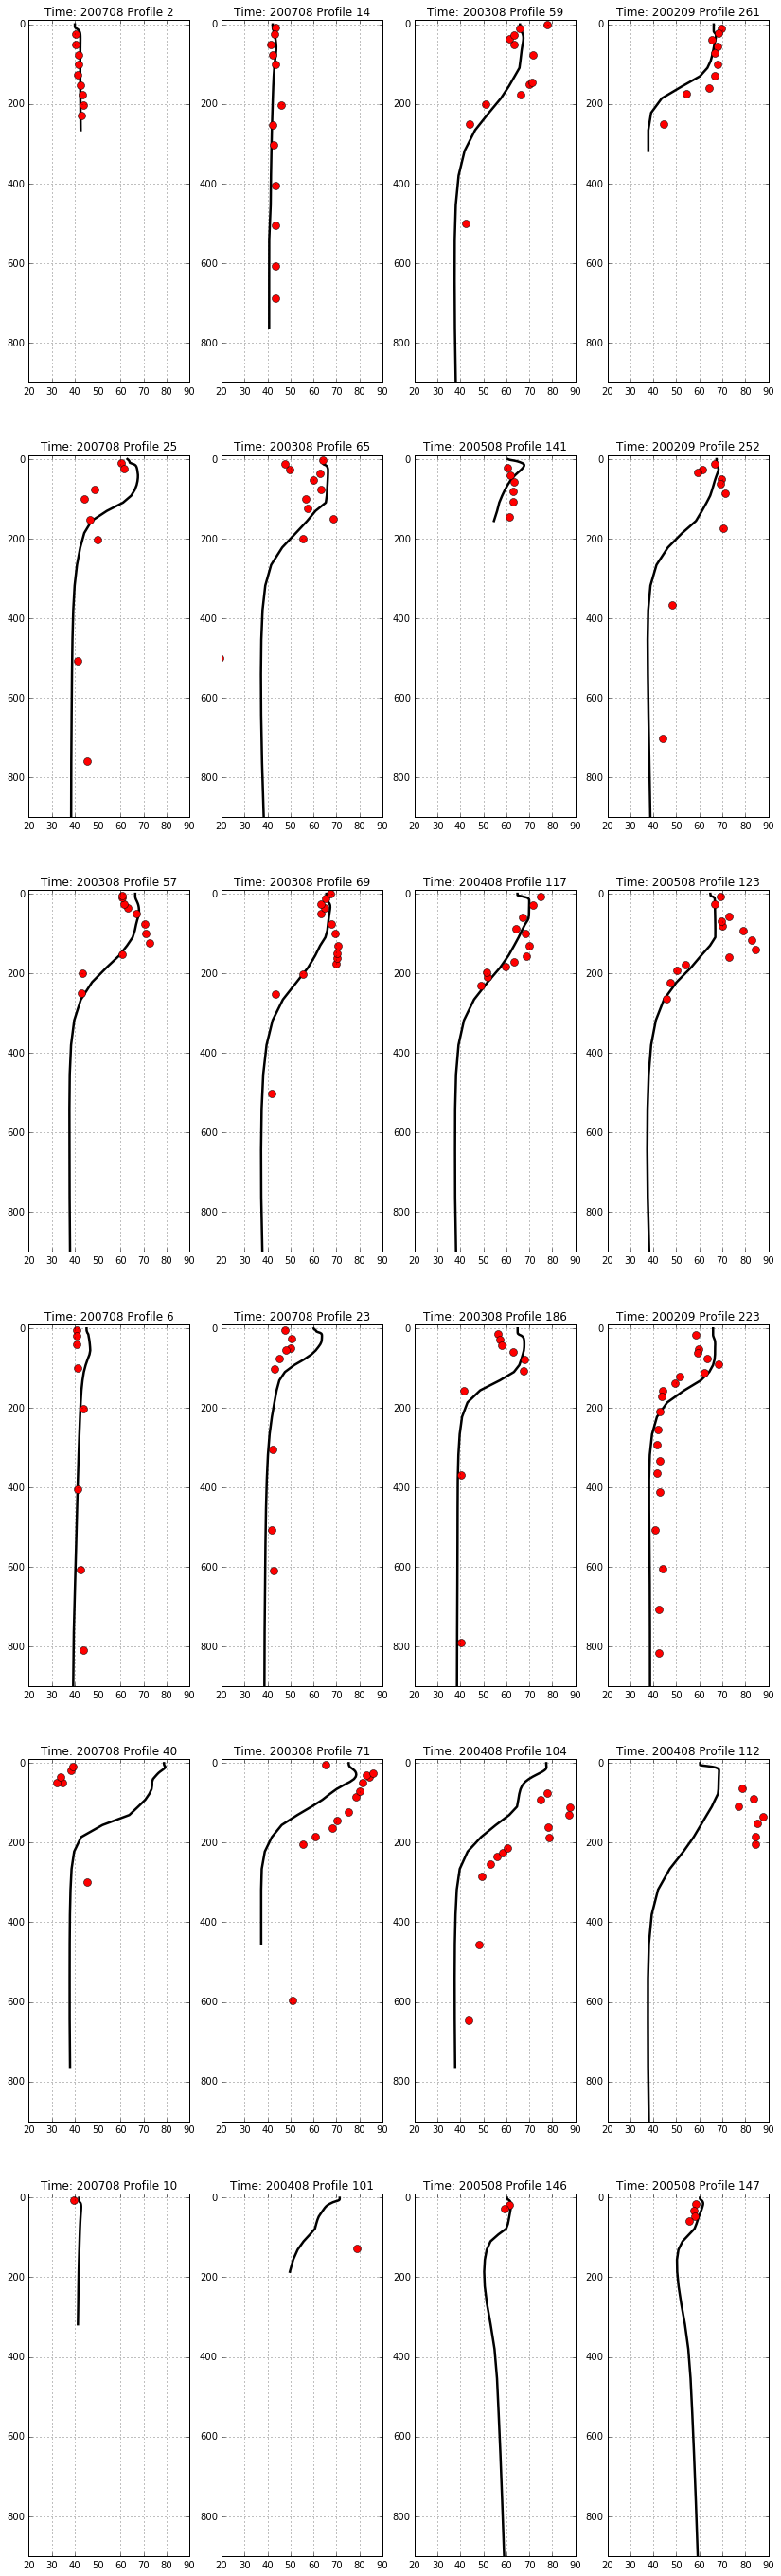

In [295]:
fig, AX = big_box()
for ax0 in AX:
    ax0.grid(); ax0.set_xlim([20, 90])
    ax0.set_ylim(-10, 900); ax0.invert_yaxis()
id_list = [2, 14, 59, 261, 25, 65, 141, 252, 57, 69, 117, 123, 6, 23, 186, 223, 40, 71, 104, 112, 10, 101, 146, 147]    
for i in range(len(id_list)):
    signle_plot(id_list[i], AX[i])

In [260]:
good_indx = locx[head_loc[good]]; good_indy = locy[head_loc[good]]
soso_indx = locx[head_loc[soso]]; soso_indy = locy[head_loc[soso]]
ueh_indx = locx[head_loc[ueh]]; ueh_indy = locy[head_loc[ueh]]
oes_indx = locx[head_loc[oes]]; oes_indy = locy[head_loc[oes]]
bad_indx = locx[head_loc[bad]]; bad_indy = locy[head_loc[bad]]
nan_indx = locx[head_loc[nan]]; nan_indy = locy[head_loc[nan]]

In [262]:
lev1 = np.arange(35, 95, 5)

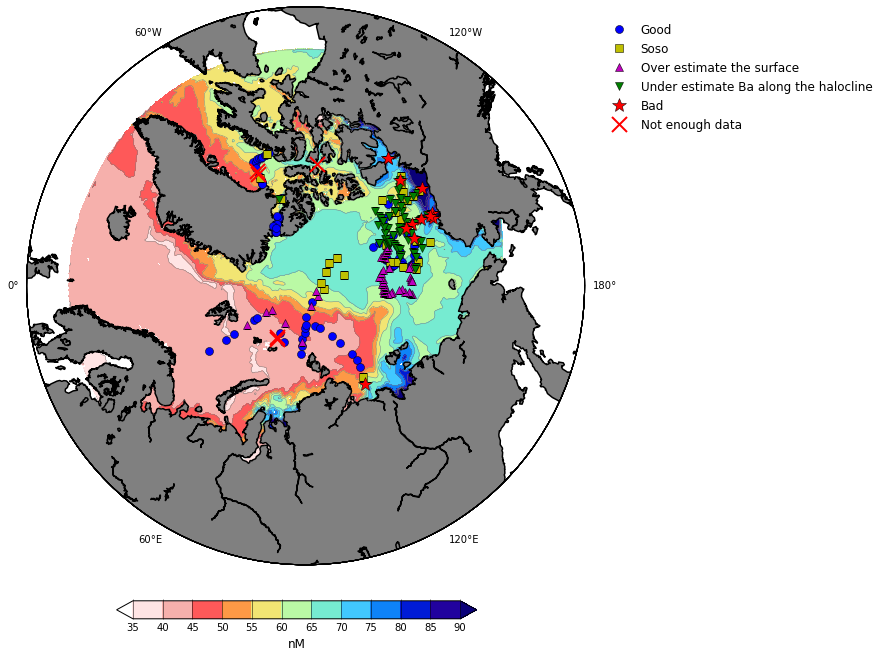

In [300]:
fig=plt.figure(figsize=(10, 10));
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(nav_lon, nav_lat)
CS=proj.contourf(x, y, Ba[-1, 0, :, :], lev1, cmap=cm.GMT_haxby_r, extend='both')
proj.contour(x, y, Ba[-1, 0, :, :], lev1, linewidths=0.5, colors=('gray',))
#for i in range(4):
proj.plot(x[good_indx, good_indy], y[good_indx, good_indy], 'bo', ms=8, label='Good')
proj.plot(x[soso_indx, soso_indy], y[soso_indx, soso_indy], 'ys', ms=8, label='Soso')
proj.plot(x[oes_indx, oes_indy], y[oes_indx, oes_indy], 'm^', ms=8, label='Over estimate the surface')
proj.plot(x[ueh_indx, ueh_indy], y[ueh_indx, ueh_indy], 'gv', ms=8, label='Under estimate Ba along the halocline')
proj.plot(x[bad_indx, bad_indy], y[bad_indx, bad_indy], 'r*', ms=15, label='Bad')
proj.plot(x[nan_indx, nan_indy], y[nan_indx, nan_indy], 'rx', ms=15, mew=2, label='Not enough data')

LG=ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=1, numpoints=1); LG.draw_frame(False)

cax = fig.add_axes([0.25, 0.05, 0.5, 0.025])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('nM', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(lev1)